# Chapter6 The Method of Godunov for Non–linear Systems

### The Riemann Problem for the Euler Equations

오일러 방정식은 3가지의 보존법칙을 의미함.
1. 질량 보존 법칙.
2. 운동량 보존 법칙.
3. 에너지 보존 법칙.

위의 보존 법칙을 하나의 시스템 수식으로 표현하면 

<img src="images/image copy 3.png" width="600">

이때 F(U)x = dF(U)/dx = dF(U)/dU * dU/dx이므로

<img src="images/image copy 4.png" width="600">
<img src="images/image copy 6.png" width="600">

여기서 A의 eigen value와 vector를 구하면 

<img src="images/image copy 5.png" width="600">

다음과 같음.
너무 복잡해서 다음에 깔끔하게 정리하겠음.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import display, clear_output

In [2]:
#Constant parameters
NUM_CELLS = 100

X_DOMAIN = [0, 1]
T_DOMAIN = [0, 0.15]
DX = (X_DOMAIN[1] - X_DOMAIN[0]) / NUM_CELLS
CFL_COEFFICIENT = 0.8
GAMMA = 1.4
X0 = 0.5
TOL = 1e-6

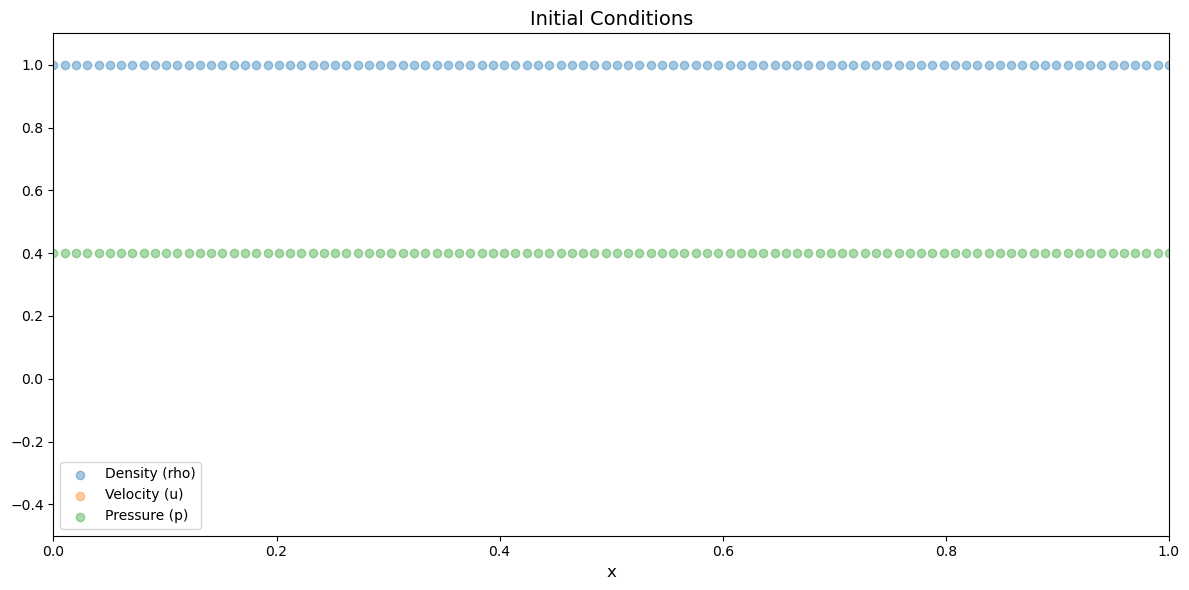

In [3]:
#Initial conditions
# +2 for cell boundary
# 0 for density, 1 for velocity, 2 for pressure
CELL = torch.zeros((NUM_CELLS + 2, 3))

border = int(X_DOMAIN[0] + X0 / DX) + 1
#left state
CELL[:border, 0] = 1.0
CELL[:border, 1] = -2.0
CELL[:border, 2] = 0.4
#right state
CELL[border:, 0] = 1
CELL[border:, 1] = 2.0
CELL[border:, 2] = 0.4

#Plot initial conditions as 1D colored points
rho_values = CELL[1:-1, 0].numpy()
u_values = CELL[1:-1, 1].numpy()
p_values = CELL[1:-1, 2].numpy()

x = np.linspace(X_DOMAIN[0], X_DOMAIN[1], NUM_CELLS)

fig, ax = plt.subplots(figsize=(12, 6))
scatter1 = ax.scatter(x, rho_values, label='Density (rho)', alpha=0.4)
scatter2 = ax.scatter(x, u_values, label='Velocity (u)', alpha=0.4)
scatter3 = ax.scatter(x, p_values, label='Pressure (p)', alpha=0.4)
ax.set_xlim(X_DOMAIN[0], X_DOMAIN[1])
ax.set_ylim(-0.5, 1.1)
ax.set_xlabel('x', fontsize=12)
ax.set_title('Initial Conditions', fontsize=14)
ax.legend()
plt.tight_layout()
plt.show()


In [4]:
#vectorized version of local_riemann_problem
#각각의 셀 경계에서의 u_{i+1/2}를 구하는 함수
def compute_f_and_df(p, LEFT_STATE, RIGHT_STATE, al, ar, Al, Ar, Bl, Br):
    
    left_shock_cell = p > LEFT_STATE[:,2]
    right_shock_cell = p > RIGHT_STATE[:,2]

    #left rarefaction wave
    fl = 2 * al / (GAMMA - 1) * ((p/LEFT_STATE[:,2])**((GAMMA - 1)/(2 * GAMMA)) - 1)
    d_fl = 1 / LEFT_STATE[:,0] / al * (p/LEFT_STATE[:,2])**(-(GAMMA + 1)/(2 * GAMMA))
  
    #overide left shock wave
    fl[left_shock_cell] = (p[left_shock_cell] - LEFT_STATE[left_shock_cell, 2]) * torch.sqrt(Al[left_shock_cell] / (p[left_shock_cell] + Bl[left_shock_cell]))
    d_fl[left_shock_cell] = torch.sqrt(Al[left_shock_cell] / (Bl[left_shock_cell] + p[left_shock_cell])) * (1 - 0.5 * (p[left_shock_cell] - LEFT_STATE[left_shock_cell, 2]) / (Bl[left_shock_cell] + p[left_shock_cell]))


    #right rarefaction wave
    fr = 2 * ar / (GAMMA - 1) * ((p/RIGHT_STATE[:,2])**((GAMMA - 1)/(2 * GAMMA)) - 1)
    d_fr = 1 / RIGHT_STATE[:,0] / ar * (p/RIGHT_STATE[:,2])**(-(GAMMA + 1)/(2 * GAMMA))
    
    #overide right shock wave
    fr[right_shock_cell] = (p[right_shock_cell] - RIGHT_STATE[right_shock_cell, 2])* torch.sqrt(Ar[right_shock_cell] / (p[right_shock_cell] + Br[right_shock_cell]))
    d_fr[right_shock_cell] = torch.sqrt(Ar[right_shock_cell] / (Br[right_shock_cell] + p[right_shock_cell])) * (1 - 0.5 * (p[right_shock_cell] - RIGHT_STATE[right_shock_cell, 2]) / (Br[right_shock_cell] + p[right_shock_cell]))

    return fl, d_fl, fr, d_fr

#vectorized version of solve_riemann_star_state
def solve_riemann_star_state(CELL):
    """
    Get the exact Riemann solution for the Euler equations.
    Newton-Raphson iterative procedure

    p(k)= p(k-1)- f(p(k-1)) / f'(p(k-1))

    return value: p*, u*, rho*l, rho*r
    """

    LEFT_STATE = CELL[:-1]
    RIGHT_STATE = CELL[1:]

    loop_count = 0

    Al = 2 / (GAMMA + 1) / LEFT_STATE[:,0]
    Ar = 2 / (GAMMA + 1) / RIGHT_STATE[:,0]
    Bl = (GAMMA - 1) / (GAMMA + 1) * LEFT_STATE[:,2]
    Br = (GAMMA - 1) / (GAMMA + 1) * RIGHT_STATE[:,2]
    al = torch.sqrt(GAMMA * LEFT_STATE[:,2] / LEFT_STATE[:,0])
    ar = torch.sqrt(GAMMA * RIGHT_STATE[:,2] / RIGHT_STATE[:,0])

    # Initial guess for the pressure
    # Should be optimaized using Two–Rarefaction approximation, primitive variables, Two–Shock approximation.
    p = 0.5 * (LEFT_STATE[:,2] + RIGHT_STATE[:,2])
    while(True):
        loop_count += 1
        prev_p = p
        fl, d_fl, fr, d_fr = compute_f_and_df(p, LEFT_STATE, RIGHT_STATE, al, ar, Al, Ar, Bl, Br)

        f = fl + fr  + RIGHT_STATE[:,1] - LEFT_STATE[:,1]
        df = d_fl + d_fr

        p = p - f / df
        #음압 방지.
        p = torch.clamp(p, min=1e-12)
        #모든 셀에서 충족하면 종료.
        if(torch.all(2 * abs(p - prev_p) < TOL * (p + prev_p)) or loop_count > 1000):
            break
    
    fl, d_fl, fr, d_fr = compute_f_and_df(p, LEFT_STATE, RIGHT_STATE, al, ar, Al, Ar, Bl, Br)
    u = 0.5 * (LEFT_STATE[:,1] + RIGHT_STATE[:,1] + fr - fl)

    left_shock_cell = p > LEFT_STATE[:, 2]
    right_shock_cell = p > RIGHT_STATE[:, 2]

    rho_l_star = LEFT_STATE[:, 0] * (p / LEFT_STATE[:, 2]) ** (1 / GAMMA)
    rho_l_star[left_shock_cell] = (
        LEFT_STATE[left_shock_cell, 0]
        * (GAMMA * (p[left_shock_cell] + LEFT_STATE[left_shock_cell, 2]) - LEFT_STATE[left_shock_cell, 2] + p[left_shock_cell])
        / (GAMMA * (p[left_shock_cell] + LEFT_STATE[left_shock_cell, 2]) - p[left_shock_cell] + LEFT_STATE[left_shock_cell, 2])
    )

    rho_r_star = RIGHT_STATE[:, 0] * (p / RIGHT_STATE[:, 2]) ** (1 / GAMMA)
    rho_r_star[right_shock_cell] = (
        RIGHT_STATE[right_shock_cell, 0]
        * (GAMMA * (p[right_shock_cell] + RIGHT_STATE[right_shock_cell, 2]) - RIGHT_STATE[right_shock_cell, 2] + p[right_shock_cell])
        / (GAMMA * (p[right_shock_cell] + RIGHT_STATE[right_shock_cell, 2]) - p[right_shock_cell] + RIGHT_STATE[right_shock_cell, 2])
    )

    return p, u, rho_l_star, rho_r_star

In [5]:
def evaluate_riemann_solution(CELL):
    """
    Solve local Riemann problem at s = 0 for all interfaces (vectorized).
    Returns tensor of shape (NUM_CELLS + 1, 3): [rho, u, p] at each interface.
    """
    LEFT_STATE = CELL[:-1]
    RIGHT_STATE = CELL[1:]

    p_star, u_star, rho_l_star, rho_r_star = solve_riemann_star_state(CELL)

    # s = 0 for Godunov flux evaluation
    s = torch.zeros_like(p_star)

    solution = torch.zeros_like(LEFT_STATE)

    # Contact side masks (s=0)
    left_contact = s < u_star
    right_contact = ~left_contact

    # Left side: rarefaction or shock
    left_rarefaction = p_star < LEFT_STATE[:, 2]
    left_shock = ~left_rarefaction

    # Right side: rarefaction or shock
    right_rarefaction = p_star < RIGHT_STATE[:, 2]
    right_shock = ~right_rarefaction

    # -------- Left rarefaction --------
    if torch.any(left_contact & left_rarefaction):
        al = torch.sqrt(GAMMA * LEFT_STATE[:, 2] / LEFT_STATE[:, 0])
        s_hl = LEFT_STATE[:, 1] - al

        # Region 1: left state
        mask_l1 = left_contact & left_rarefaction & (s < s_hl) 
        if torch.any(mask_l1):
            solution[mask_l1, 0] = LEFT_STATE[mask_l1, 0]
            solution[mask_l1, 1] = LEFT_STATE[mask_l1, 1]
            solution[mask_l1, 2] = LEFT_STATE[mask_l1, 2]

        # Region 2: star left
        al_star = al * (p_star / LEFT_STATE[:, 2]) ** ((GAMMA - 1) / (2 * GAMMA))
        s_tl = u_star - al_star
        mask_l2 = left_contact & left_rarefaction & (s > s_tl)
        if torch.any(mask_l2):
            solution[mask_l2, 0] = rho_l_star[mask_l2]
            solution[mask_l2, 1] = u_star[mask_l2]
            solution[mask_l2, 2] = p_star[mask_l2]

        # Region 3: inside fan
        mask_l3 = left_contact & left_rarefaction & ~(s < s_hl) & ~(s > s_tl)
        if torch.any(mask_l3):
            p = LEFT_STATE[:, 2] * ((2 * al + (GAMMA - 1) * (LEFT_STATE[:, 1] - s)) / (al * (GAMMA + 1))) ** (2 * GAMMA / (GAMMA - 1))
            u = 2 / (GAMMA + 1) * (al + (GAMMA - 1) / 2 * LEFT_STATE[:, 1] + s)
            rho = LEFT_STATE[:, 0] * ((2 * al + (GAMMA - 1) * (LEFT_STATE[:, 1] - s)) / (al * (GAMMA + 1))) ** (2 / (GAMMA - 1))
            solution[mask_l3, 0] = rho[mask_l3]
            solution[mask_l3, 1] = u[mask_l3]
            solution[mask_l3, 2] = p[mask_l3]

    # -------- Left shock --------
    if torch.any(left_contact & left_shock):
        al = torch.sqrt(GAMMA * LEFT_STATE[:, 2] / LEFT_STATE[:, 0])
        s_l = LEFT_STATE[:, 1] - al * torch.sqrt((GAMMA * (p_star + LEFT_STATE[:, 2]) + p_star - LEFT_STATE[:, 2]) / (2 * GAMMA * LEFT_STATE[:, 2]))
        mask_ls = left_contact & left_shock & (s < s_l)
        solution[mask_ls, 0] = LEFT_STATE[mask_ls, 0]
        solution[mask_ls, 1] = LEFT_STATE[mask_ls, 1]
        solution[mask_ls, 2] = LEFT_STATE[mask_ls, 2]

        mask_ls2 = left_contact & left_shock & ~(s < s_l)
        solution[mask_ls2, 0] = rho_l_star[mask_ls2]
        solution[mask_ls2, 1] = u_star[mask_ls2]
        solution[mask_ls2, 2] = p_star[mask_ls2]

    # -------- Right rarefaction --------
    if torch.any(right_contact & right_rarefaction):
        ar = torch.sqrt(GAMMA * RIGHT_STATE[:, 2] / RIGHT_STATE[:, 0])
        s_hr = RIGHT_STATE[:, 1] + ar

        # Region 1: right state
        mask_r1 = right_contact & right_rarefaction & (s > s_hr)
        solution[mask_r1, 0] = RIGHT_STATE[mask_r1, 0]
        solution[mask_r1, 1] = RIGHT_STATE[mask_r1, 1]
        solution[mask_r1, 2] = RIGHT_STATE[mask_r1, 2]

        # Region 2: star right
        ar_star = ar * (p_star / RIGHT_STATE[:, 2]) ** ((GAMMA - 1) / (2 * GAMMA))
        s_tr = u_star + ar_star
        mask_r2 = right_contact & right_rarefaction & (s > s_tr)
        solution[mask_r2, 0] = rho_r_star[mask_r2]
        solution[mask_r2, 1] = u_star[mask_r2]
        solution[mask_r2, 2] = p_star[mask_r2]

        # Region 3: inside fan
        mask_r3 = right_contact & right_rarefaction & ~(s > s_hr) & ~(s > s_tr)
        if torch.any(mask_r3):
            p = RIGHT_STATE[:, 2] * ((2 * ar + (GAMMA - 1) * (s - RIGHT_STATE[:, 1])) / (ar * (GAMMA + 1))) ** (2 * GAMMA / (GAMMA - 1))
            u = 2 / (GAMMA + 1) * (-ar + (GAMMA - 1) / 2 * RIGHT_STATE[:, 1] + s)
            rho = RIGHT_STATE[:, 0] * ((2 * ar + (GAMMA - 1) * (s - RIGHT_STATE[:, 1])) / (ar * (GAMMA + 1))) ** (2 / (GAMMA - 1))
            solution[mask_r3, 0] = rho[mask_r3]
            solution[mask_r3, 1] = u[mask_r3]
            solution[mask_r3, 2] = p[mask_r3]

    # -------- Right shock --------
    if torch.any(right_contact & right_shock):
        ar = torch.sqrt(GAMMA * RIGHT_STATE[:, 2] / RIGHT_STATE[:, 0])
        s_r = RIGHT_STATE[:, 1] + ar * torch.sqrt((GAMMA * (p_star + RIGHT_STATE[:, 2]) + p_star - RIGHT_STATE[:, 2]) / (2 * GAMMA * RIGHT_STATE[:, 2]))
        mask_rs = right_contact & right_shock & (s > s_r)
        solution[mask_rs, 0] = RIGHT_STATE[mask_rs, 0]
        solution[mask_rs, 1] = RIGHT_STATE[mask_rs, 1]
        solution[mask_rs, 2] = RIGHT_STATE[mask_rs, 2]

        mask_rs2 = right_contact & right_shock & ~(s > s_r)
        solution[mask_rs2, 0] = rho_r_star[mask_rs2]
        solution[mask_rs2, 1] = u_star[mask_rs2]
        solution[mask_rs2, 2] = p_star[mask_rs2]

    return solution


### the conservative formula
$$u^{n+1}_i = u^n_i + \frac{\Delta t}{\Delta x}\left(f_{i-\frac{1}{2}} - f_{i+\frac{1}{2}}\right)$$

In general, one expresses the Godunov intercell numerical flux as
$$f^{\text{god}}_{i+\frac{1}{2}} = f\left(u_{i+\frac{1}{2}}(0)\right)$$


### dt calculation to satisfy CFL coefficient.

(speed of characteristic) / (speed of cell) <= CFL_COEFFICIENT

--> MAX(|u|) / (DX / DT) = CFL_COEFFICIENT

CFL_COEFFICIENT * (DX / DT) = MAX(u)

DT = CFL_COEFFICIENT * DX / MAX(u)

MAX(u) = max(|u| + a)

In [6]:
def cal_dt(CELL):
    a = torch.sqrt(GAMMA * CELL[:, 2] / CELL[:, 0])
    u = CELL[:, 1]
    return CFL_COEFFICIENT * DX / (u.abs() + a).max()

<img src="images/image copy 7.png" width="600">


In [7]:
#caluculate flux at each cell
def cal_flux(CELL):
    flux = torch.zeros_like(CELL)
    #rho_flux = rho * u
    flux[:, 0] = CELL[:, 0] * CELL[:, 1]
    #u_flux = u^2 + p/rho
    flux[:, 1] = CELL[:, 1]**2 + CELL[:, 2] / CELL[:, 0]
    #p_flux = gamma * p * u
    flux[:, 2] = GAMMA * CELL[:, 2] * CELL[:, 1]
    return flux


In [ ]:
def update(DX, CELL):
    """
    CELL: (N+2, 3) - [rho, u, p] primitive variables (with ghost cells)
    """
    # Riemann solver로 cell interface에서 primitive variables 얻기
    inter_cell = evaluate_riemann_solution(CELL)  # (N+1, 3) - [rho, u, p]
    
    # 보존량 형태로 변환: U = [ρ, ρu, E]
    rho = inter_cell[:, 0]
    u = inter_cell[:, 1]
    p = inter_cell[:, 2]
    E = p / (GAMMA - 1) + 0.5 * rho * u**2
    U_inter = torch.stack([
        rho,           # ρ
        rho * u,       # ρu
        E              # E
    ], dim=1)  # (N+1, 3)
    
    # 플럭스 계산 (보존량 형태)
    flux = torch.stack([
        rho * u,                    # F_ρ
        rho * u**2 + p,             # F_m
        u * (E + p)                 # F_E
    ], dim=1)  # (N+1, 3)
    
    # 현재 cell의 보존량 계산
    rho_cell = CELL[1:-1, 0]
    u_cell = CELL[1:-1, 1]
    p_cell = CELL[1:-1, 2]
    E_cell = p_cell / (GAMMA - 1) + 0.5 * rho_cell * u_cell**2
    U_cell = torch.stack([
        rho_cell,
        rho_cell * u_cell,
        E_cell
    ], dim=1)  # (N, 3)
    
    # 보존량 업데이트
    dt = cal_dt(CELL).item()
    U_new = U_cell + dt/DX * (flux[:-1] - flux[1:])  # (N, 3)
    
    # 보존량 → primitive 변환
    rho_new = U_new[:, 0]
    u_new = U_new[:, 1] / rho_new
    E_new = U_new[:, 2]
    p_new = (GAMMA - 1) * (E_new - 0.5 * rho_new * u_new**2)
    
    # CELL 업데이트
    CELL[1:-1, 0] = rho_new
    CELL[1:-1, 1] = u_new
    CELL[1:-1, 2] = p_new
    
    # 경계 조건
    #Transmissive Boundaries
    CELL[0] = CELL[1]
    CELL[-1] = CELL[-2]
    
    return CELL, dt

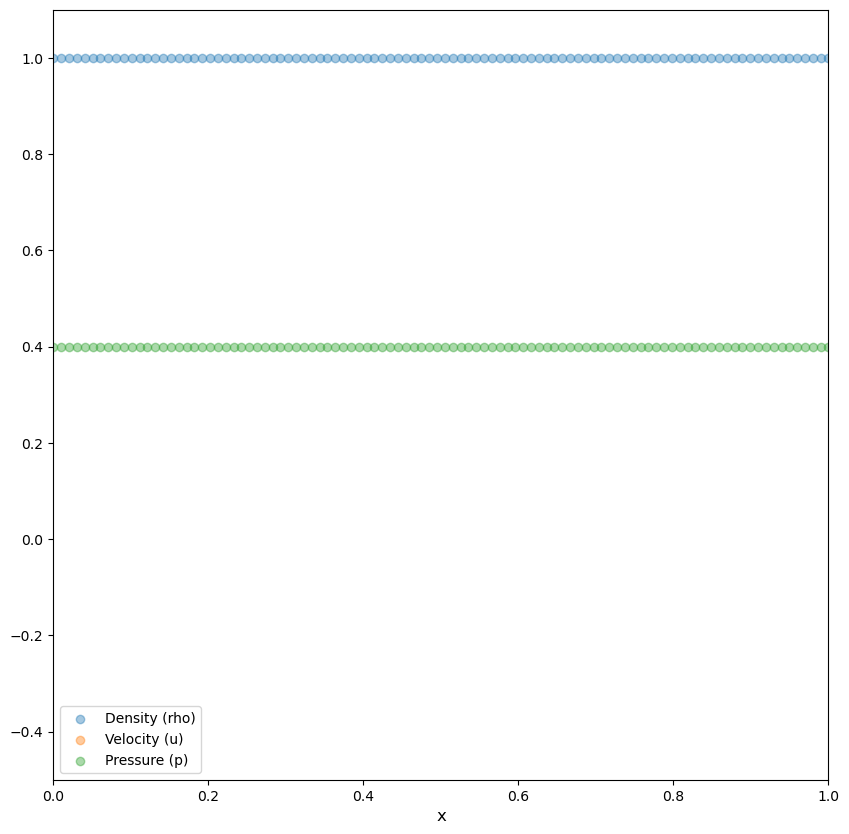

In [ ]:
# Setup figure and axis
fig, ax = plt.subplots(figsize=(10, 10))
x = np.linspace(X_DOMAIN[0], X_DOMAIN[1], NUM_CELLS)

# Initial plot
rho_values = CELL[1:-1, 0].numpy()
u_values = CELL[1:-1, 1].numpy()
p_values = CELL[1:-1, 2].numpy()

ax.scatter(x, rho_values, label='Density (rho)', alpha=0.4)
ax.scatter(x, u_values, label='Velocity (u)', alpha=0.4)
ax.scatter(x, p_values, label='Pressure (p)', alpha=0.4)
ax.set_xlim(X_DOMAIN[0], X_DOMAIN[1])
ax.set_ylim(-0.5, 1.1)
ax.set_xlabel('x', fontsize=12)
ax.legend()

# Animation parameters
TOTAL_T = T_DOMAIN[1] - T_DOMAIN[0]
t = 0.0

# Animation function
def animate(frame):
    global CELL, t

    CELL, dt = update(DX, CELL)
    t = t + dt

    # Clear previous frame
    ax.cla()

    # Redraw scatter plot
    rho_values = CELL[1:-1, 0].numpy()
    u_values = CELL[1:-1, 1].numpy()
    p_values = CELL[1:-1, 2].numpy()
    ax.scatter(x, rho_values, label='Density (rho)', alpha=0.4)
    ax.scatter(x, u_values, label='Velocity (u)', alpha=0.4)
    ax.scatter(x, p_values, label='Pressure (p)', alpha=0.4)

    # Restore axes settings
    ax.set_xlim(X_DOMAIN[0], X_DOMAIN[1])
    #ax.set_ylim(-0.5, 1.1)
    ax.set_xlabel('x', fontsize=12)
    ax.legend()

    # Update title
    ax.set_title(f'Solution at t = {t:.3f}', fontsize=14)
    clear_output(wait=True)
    display(fig)
    
    return ax.collections

In [10]:
def frame_generator():
    global t
    while t < T_DOMAIN[1]:
        yield None


# Create animation
anim = animation.FuncAnimation(
    fig,
    animate,
    frames=frame_generator(),
    interval=50,
    blit=False,
    cache_frame_data=False
)

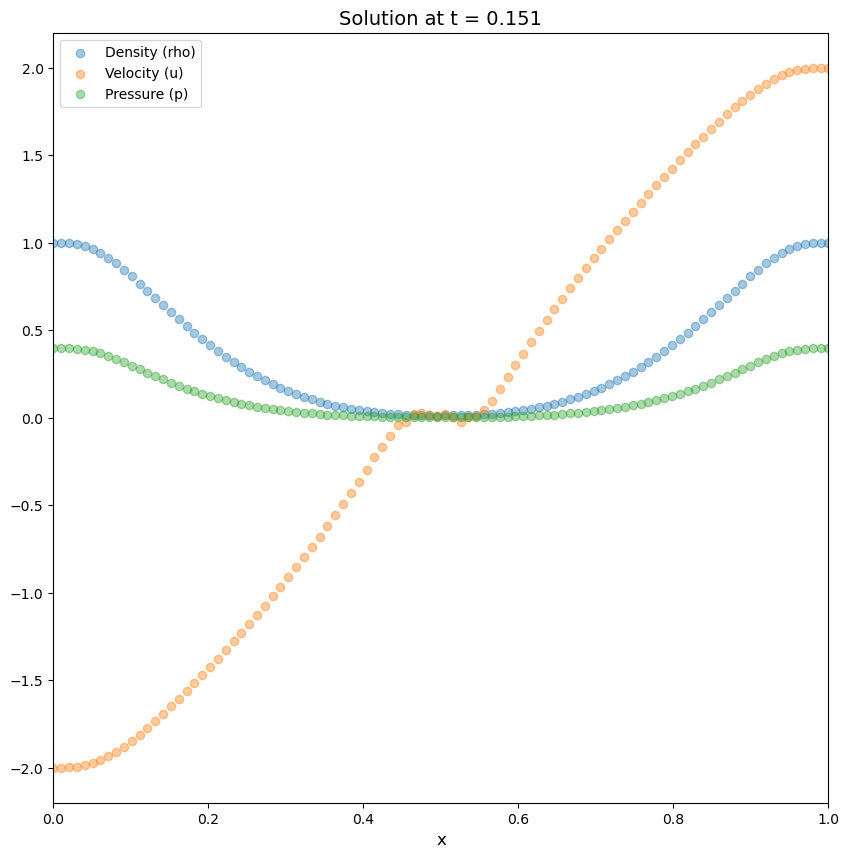

In [11]:
anim.save("Godunov_Euler_eq.mp4", writer=animation.FFMpegWriter(fps=25))